In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [2]:
# read data from file
train = pd.read_csv("./input/train.csv") 
test = pd.read_csv("./input/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [3]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [4]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [5]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [6]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [7]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [8]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [9]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [10]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [11]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [12]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'os_name', 'SIM 2', 'RAM', 'Height', 'Pixel Density',
       'Screen Size', 'Capacity', 'Internal Memory', 'Processor_frequency',
       'SIM Slot(s)', 'Brand', 'Weight', 'Resolution',
       'Screen to Body Ratio (calculated)', 'Sim1', 'Num_cores'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'RAM', 'Height', 'Pixel Density', 'Screen Size', 'Capacity',
       'Internal Memory', 'Processor_frequency', 'Weight', 'Resolution',
       'Screen to Body Ratio (calculated)', 'os_name_Android',
       'os_name_Blackberry', 'os_name_KAI', 'os_name_Nokia', 'os_name_Other',
       'os_name_Tizen', 'os_name_iOS', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G',
       'SIM 2_Other', 'SIM Slot(s)_Dual SIM, GSM+CDMA',
       'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'Brand_10.or', 'Brand_Apple',
       'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio',
       'Brand_Coolpad', 'Brand_D

In [13]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [14]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [15]:
train_new.head()

,PhoneId,RAM,Height,Pixel Density,Screen Size,Capacity,Internal Memory,Processor_frequency,Weight,Resolution,...,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Rating
0,0,4,157.9,403,6.26,4000,64,1.8,182,20,...,True,False,False,False,False,True,False,False,False,4.5
1,1,3,156.2,271,6.20,4230,32,1.8,168,8,...,True,False,False,False,False,True,False,False,False,4.5
2,2,3,157.0,409,6.30,3500,32,2.1,168,25,...,True,False,False,False,False,True,False,False,False,4.4
3,4,4,159.8,411,6.00,3300,64,2.2,169,24,...,True,False,False,False,False,True,False,False,False,4.3
4,5,4,160.4,396,6.50,3750,64,2.2,175,16,...,True,False,False,False,False,True,False,False,False,4.4


In [16]:
test_new.head()

,PhoneId,RAM,Height,Pixel Density,Screen Size,Capacity,Internal Memory,Processor_frequency,Weight,Resolution,...,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
0,3,2,156.2,271,6.20,4230,16,1.8,168,5,...,False,True,False,False,False,False,True,False,False,False
1,11,4,156.0,402,6.20,5000,64,1.8,205,12,...,False,True,False,False,False,False,True,False,False,False
2,13,6,156.7,409,6.30,3500,64,2.0,169,25,...,False,True,False,False,False,False,True,False,False,False
3,16,4,156.7,409,6.30,3500,64,2.0,169,16,...,False,True,False,False,False,False,True,False,False,False
4,19,4,158.6,403,5.99,4000,64,1.8,181,20,...,False,True,False,False,False,False,True,False,False,False


## Dummy Solution

In [17]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':[0]*test_new.shape[0]})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,0
1,11,0
2,13,0
3,16,0
4,19,0


In [18]:
submission.to_csv("submission.csv", index=False)

In [19]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 88 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   PhoneId                                    341 non-null    int64  
 1   RAM                                        341 non-null    int64  
 2   Height                                     341 non-null    float64
 3   Pixel Density                              341 non-null    int64  
 4   Screen Size                                341 non-null    float64
 5   Capacity                                   341 non-null    int64  
 6   Internal Memory                            341 non-null    int64  
 7   Processor_frequency                        341 non-null    float64
 8   Weight                                     341 non-null    int64  
 9   Resolution                                 341 non-null    int64  
 10  Screen to Body Ratio (calc

In [20]:
(train_new['Capacity']>3000).sum()

np.int64(182)

In [21]:
train_new.describe()

,PhoneId,RAM,Height,Pixel Density,Screen Size,Capacity,Internal Memory,Processor_frequency,Weight,Resolution,Screen to Body Ratio (calculated),Rating
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,232.970674,11.120235,149.946394,344.211144,5.462317,3191.307918,46.369501,1.792551,161.343109,9.592375,72.353343,4.072434
std,137.231746,61.320855,9.192305,88.161129,0.742529,932.533527,46.435453,0.451598,22.305556,5.953827,9.357839,0.377066
min,0.000000,1.000000,115.600000,143.000000,2.400000,1020.000000,0.000000,1.000000,58.000000,2.000000,23.600000,2.500000
25%,110.000000,2.000000,146.200000,282.000000,5.200000,2900.000000,16.000000,1.400000,150.000000,5.000000,68.800000,3.900000
50%,229.000000,3.000000,151.300000,326.000000,5.500000,3055.000000,32.000000,1.800000,161.000000,8.000000,72.500000,4.100000
75%,354.000000,4.000000,156.200000,403.000000,6.000000,3750.000000,64.000000,2.200000,172.000000,13.000000,77.480000,4.300000
max,472.000000,512.000000,174.100000,576.000000,6.590000,13000.000000,512.000000,2.800000,330.000000,25.000000,87.660000,5.000000


In [22]:
# Get the class column
train_new['Class'] = train_new['Rating']>=train_new['Rating'].quantile()
train_new.drop("Rating", axis=1,inplace=True)

In [23]:
train_new.head()

,PhoneId,RAM,Height,Pixel Density,Screen Size,Capacity,Internal Memory,Processor_frequency,Weight,Resolution,...,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Class
0,0,4,157.9,403,6.26,4000,64,1.8,182,20,...,True,False,False,False,False,True,False,False,False,True
1,1,3,156.2,271,6.20,4230,32,1.8,168,8,...,True,False,False,False,False,True,False,False,False,True
2,2,3,157.0,409,6.30,3500,32,2.1,168,25,...,True,False,False,False,False,True,False,False,False,True
3,4,4,159.8,411,6.00,3300,64,2.2,169,24,...,True,False,False,False,False,True,False,False,False,True
4,5,4,160.4,396,6.50,3750,64,2.2,175,16,...,True,False,False,False,False,True,False,False,False,True


In [24]:
from pandas.api.types import is_bool_dtype, is_numeric_dtype

def preprocess_data(df):
    """Preprocessing function."""
    df_new = df.copy()

    # Drop the PhoneID column (assuming 'PhoneID' is the correct name)
    df_new.drop("PhoneId", axis=1, inplace=True)

    for column in df_new.columns:
        if is_bool_dtype(df_new[column]):
            df_new[column] = df_new[column].astype(int)
        elif is_numeric_dtype(df_new[column]):
            # Quantile-based conversion
            max_col = df_new[column].max()
            min_col = df_new[column].min()
            df_new[column] = (df_new[column]-min_col)/(max_col- min_col)
        else:
            pass

    return df_new


In [25]:
train_new_1 = preprocess_data(train_new)
train_new_1.head()

,RAM,Height,Pixel Density,Screen Size,Capacity,Internal Memory,Processor_frequency,Weight,Resolution,Screen to Body Ratio (calculated),...,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Class
0,0.005871,0.723077,0.600462,0.921241,0.248748,0.1250,0.444444,0.455882,0.782609,0.891040,...,1,0,0,0,0,1,0,0,0,1
1,0.003914,0.694017,0.295612,0.906921,0.267947,0.0625,0.444444,0.404412,0.260870,0.893693,...,1,0,0,0,0,1,0,0,0,1
2,0.003914,0.707692,0.614319,0.930788,0.207012,0.0625,0.611111,0.404412,1.000000,0.937871,...,1,0,0,0,0,1,0,0,0,1
3,0.005871,0.755556,0.618938,0.859189,0.190317,0.1250,0.666667,0.408088,0.956522,0.798938,...,1,0,0,0,0,1,0,0,0,1
4,0.005871,0.765812,0.584296,0.978520,0.227880,0.1250,0.666667,0.430147,0.608696,0.946456,...,1,0,0,0,0,1,0,0,0,1


In [26]:
test_new.head()

,PhoneId,RAM,Height,Pixel Density,Screen Size,Capacity,Internal Memory,Processor_frequency,Weight,Resolution,...,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
0,3,2,156.2,271,6.20,4230,16,1.8,168,5,...,False,True,False,False,False,False,True,False,False,False
1,11,4,156.0,402,6.20,5000,64,1.8,205,12,...,False,True,False,False,False,False,True,False,False,False
2,13,6,156.7,409,6.30,3500,64,2.0,169,25,...,False,True,False,False,False,False,True,False,False,False
3,16,4,156.7,409,6.30,3500,64,2.0,169,16,...,False,True,False,False,False,False,True,False,False,False
4,19,4,158.6,403,5.99,4000,64,1.8,181,20,...,False,True,False,False,False,False,True,False,False,False


In [27]:
test_new_1 = preprocess_data(test_new)
test_new_1.head()

,RAM,Height,Pixel Density,Screen Size,Capacity,Internal Memory,Processor_frequency,Weight,Resolution,Screen to Body Ratio (calculated),...,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
0,0.001957,0.717496,0.248811,0.936170,0.806533,0.0625,0.376344,0.557522,0.130435,0.931169,...,0,1,0,0,0,0,1,0,0,0
1,0.005871,0.714286,0.456418,0.936170,1.000000,0.2500,0.376344,0.884956,0.434783,0.942441,...,0,1,0,0,0,0,1,0,0,0
2,0.009785,0.725522,0.467512,0.957447,0.623116,0.2500,0.483871,0.566372,1.000000,0.976105,...,0,1,0,0,0,0,1,0,0,0
3,0.005871,0.725522,0.467512,0.957447,0.623116,0.2500,0.483871,0.566372,0.608696,0.976105,...,0,1,0,0,0,0,1,0,0,0
4,0.005871,0.756019,0.458003,0.891489,0.748744,0.2500,0.376344,0.672566,0.782609,0.879772,...,0,1,0,0,0,0,1,0,0,0


In [28]:
X_train = train_new_1.drop("Class", axis=1).values
y_train = train_new_1.Class.values
x_test = test_new_1.values

In [29]:
from sklearn.metrics import accuracy_score

Max Accuracy :  0.8093841642228738


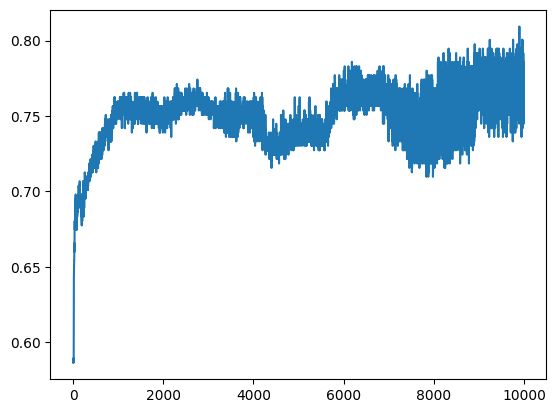

In [30]:
class Perceptron:
    def __init__(self):
        self.w = None
        self.b = None
    
    def model(self,x):
        return 1 if np.dot(self.w,x) >= self.b else 0
    
    def predict(self, X):
        Y = []
        for x in X:
            result = self.model(x)
            Y.append(result)
        return np.array(Y)
    
    def fit(self, X, Y, epochs = 1, lr = 1):
        self.w = np.ones(X.shape[1])
        self.b = 0
        
        accuracy = {}
        max_accuracy = 0
        wt_matrix = []
        
        for i in range(epochs):
            for x,y in zip(X, Y):
                ypred = self.model(x)
                if y == 1 and ypred == 0:
                    self.w += lr * x
                    self.b += lr * 1
                elif y == 0 and ypred == 1:
                    self.w -= lr * x
                    self.b -= lr * 1
            
            wt_matrix.append(self.w)
            accuracy[i] = accuracy_score(self.predict(X),Y)
            
            if max_accuracy<accuracy[i]:
                max_accuracy = accuracy[i]
                chkptw = self.w
                chkptb = self.b
        
        self.w = chkptw
        self.b = chkptb
                
        print("Max Accuracy : ",max_accuracy)
        if epochs > 1:
            plt.plot(list(accuracy.values()))
            plt.show()
        
        return np.array(wt_matrix)
    
perceptron = Perceptron()
perceptron.fit(X_train, y_train, 10000,0.001)
y_pred = perceptron.predict(x_test)

In [31]:
submission = pd.DataFrame()
submission['PhoneId'] = test_new['PhoneId']
submission['Class'] = y_pred
submission.head()
#submission.to_csv("submission.csv", index=False)

,PhoneId,Class
0,3,1
1,11,1
2,13,1
3,16,1
4,19,1


In [32]:
submission.to_csv("submission.csv", index=False)

In [35]:
# Score: 0.76470

In [34]:
submission.Class.value_counts()

Class
1    109
0     10
Name: count, dtype: int64